In [1]:
%run stdPackages.ipynb
slides = True # print to slides format if True
out_folder = os.path.join(d['curr'], 'Misc', 'Figs','quiz')
d['data'] = os.path.join(d['curr'],'Misc','Data')
read = {'variables': ['Fundamentals', 'LoadVariables', 'TransmissionLines', 'GeneratorsVariables'],
        'maps': ['LoadMaps','GeneratorsMaps'],
        'variable2D': ['LoadVariation_E','LoadVariation_H','HourlyVariation'],
        'scalars': ['Scalars']}
db = dbFromWB(os.path.join(d['data'],'mGF_PH_ThellufsenEtAl2022.xlsx'), read)
readSets(db)

# Greenfield experiments with Danish-looking aggregate data

### 1. Descriptive

Let's start by plotting time series data. Collect all hourly variation in one dataframe:

In [2]:
load_E = db['LoadVariation_E'].rename_axis(index={'c_E':'hvt'})
load_E.index = load_E.index.set_levels('Load E_'+load_E.index.levels[-1], level='hvt')
load_H = db['LoadVariation_H'].rename_axis(index={'c_H':'hvt'})
load_H.index = load_H.index.set_levels('Load H_'+load_H.index.levels[-1], level='hvt')
df_H = pd.concat([db['CapVariation'].unstack('hvt'), load_E.unstack('hvt'), load_H.unstack('hvt')], axis=1).astype(float)

Split the samples into DK1 and DK2 time series':

In [3]:
DK1 = df_H.columns[df_H.columns.str.contains('DK1')].union(['SH'])
DK2 = df_H.columns[df_H.columns.str.contains('DK2')].union(['SH'])
df_DK1 = df_H[DK1]
df_DK2 = df_H[DK2]
df_DK1.columns = df_DK1.columns.str.strip('_DK1')
df_DK2.columns = df_DK1.columns.str.strip('_DK2')
print(df_DK1.corr().round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
hvt &    PV &  WNearShore &  WOffShore &  WOnShore &  Load E &  Load H &    SH \\
hvt        &       &             &            &           &         &         &       \\
\midrule
PV         &  1.00 &       -0.20 &      -0.21 &     -0.15 &    0.18 &   -0.27 &  0.49 \\
WNearShore & -0.20 &        1.00 &       0.77 &      0.91 &    0.28 &    0.39 & -0.22 \\
WOffShore  & -0.21 &        0.77 &       1.00 &      0.82 &    0.20 &    0.34 & -0.18 \\
WOnShore   & -0.15 &        0.91 &       0.82 &      1.00 &    0.26 &    0.40 & -0.18 \\
Load E     &  0.18 &        0.28 &       0.20 &      0.26 &    1.00 &    0.34 & -0.10 \\
Load H     & -0.27 &        0.39 &       0.34 &      0.40 &    0.34 &    1.00 & -0.35 \\
SH         &  0.49 &       -0.22 &      -0.18 &     -0.18 &   -0.10 &   -0.35 &  1.00 \\
\bottomrule
\end{tabular}



In [4]:
print(df_DK2.corr().round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
hvt &    PV &  WNearShore &  WOffShore &  WOnShore &  Load E &  Load H &    SH \\
hvt        &       &             &            &           &         &         &       \\
\midrule
PV         &  1.00 &       -0.21 &      -0.13 &     -0.13 &    0.16 &   -0.23 &  0.48 \\
WNearShore & -0.21 &        1.00 &       0.87 &      0.82 &    0.20 &    0.29 & -0.21 \\
WOffShore  & -0.13 &        0.87 &       1.00 &      0.76 &    0.17 &    0.24 & -0.16 \\
WOnShore   & -0.13 &        0.82 &       0.76 &      1.00 &    0.28 &    0.36 & -0.20 \\
Load E     &  0.16 &        0.20 &       0.17 &      0.28 &    1.00 &    0.40 & -0.12 \\
Load H     & -0.23 &        0.29 &       0.24 &      0.36 &    0.40 &    1.00 & -0.34 \\
SH         &  0.48 &       -0.21 &      -0.16 &     -0.20 &   -0.12 &   -0.34 &  1.00 \\
\bottomrule
\end{tabular}



The marginal costs:

In [5]:
m = mGF_PH.mSimple(db)
m.preSolve()

### 2. Create *design days approach*-like input data from full yearly samples

In [6]:
db_before = db.copy()

*Create representative days for each month instead:*

In [7]:
lm = [31,28,31,30,31,30,31,31,30,31,30,31] # number of days in the months
months = [i for l in [[j+1]*24*lm[j] for j in range(len(lm))] for i in l]
hours  = [j for l in [range(1,25)]*365 for j in l]
map_ = pd.MultiIndex.from_arrays([db['h'], hours, months], names = ['h','h_new','month'])
map2flat = pd.MultiIndex.from_arrays([pd.MultiIndex.from_arrays([months,hours]).to_flat_index(),months,hours], names = ['h','month','h_new']).unique()
map_flat = pd.MultiIndex.from_arrays([db['h'], pd.MultiIndex.from_arrays([months,hours]).to_flat_index()], names = ['h','h_new'])

*Use a version of aggregation that uses extreme values instead of averages (if a cluster group is below average --> use minimum observation, if a cluster group is above average --> use maximum observation):*

In [8]:
def aggregateV1(v, map_, map2flat):
    """ Map variable 'v' to hours and months. Flatten index to 1d"""
    v_gb = applyMult(v,map_).groupby(list(set(v.index.names).union(['h_new','month'])-set('h')))
    v_min,v_mean,v_max = v_gb.min()*v_gb.count(), v_gb.sum(), v_gb.max()*v_gb.count()
    mean_ = v_mean.groupby(list(set(v.index.names).union(['month'])-set('h'))).mean()
    v_new = pd.concat([v_min[(v_mean-mean_<=0).reorder_levels(v_mean.index.names)], v_max[(v_mean-mean_>0).reorder_levels(v_mean.index.names)]])
    v_new = applyMult(v_new, map2flat).droplevel(['h_new','month']).reorder_levels(v.index.names)
    return v_new * pdSum(v,'h') / pdSum(v_new,'h')
def aggregateV2(v, map_flat):
    """ Map variable 'v' to flat index of months/hours directly. """
    v_gb = applyMult(v,map_).groupby([k if k!='h' else 'h_new' for k in v.index.names])
    v_min,v_mean,v_max = v_gb.min()*v_gb.count(), v_gb.sum(), v_gb.max()*v_gb.count()
    mean_ = v_mean.groupby([k for k in v.index.names if k!='h']).mean()
    v_new = pd.concat([v_min[v_mean-mean_<=0], v_max[v_mean-mean_>0]]).rename_axis(index={'h_new':'h'})
    return v_new * pdSum(v,'h')/ pdSum(v_new,'h')

*Update symbols in database*

In [9]:
[db.__setitem__(k,aggregateV1(db[k], map_, map2flat)) for k in db.variableDomains('h')];
# [db.__setitem__(k,aggregateV2(db[k], map_flat)) for k in db.variableDomains('h')];
db['h'] = db['CapVariation'].index.levels[0] # update 'h' as well

In [10]:
mSimple = m

### 3. Baseline model without aggregate capacity constraints

In [12]:
m

In [11]:
m = mGF_PH.mMultipleConsumers(db)
m.solve()

C:\Users\sxj477\Anaconda3\lib\site-packages\pandas\core\indexes\multi.py:3559: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  result = lib.fast_unique_multiple([self._values, rvals], sort=sort)


TypeError: SparseArray does not support item assignment via setitem

In [11]:
m.globalDomains['HourlyDemand_E']

MultiIndex([('DK1', 'DK1',   (1, 1)),
            ('DK1', 'DK1',   (1, 2)),
            ('DK1', 'DK1',   (1, 3)),
            ('DK1', 'DK1',   (1, 4)),
            ('DK1', 'DK1',   (1, 5)),
            ('DK1', 'DK1',   (1, 6)),
            ('DK1', 'DK1',   (1, 7)),
            ('DK1', 'DK1',   (1, 8)),
            ('DK1', 'DK1',   (1, 9)),
            ('DK1', 'DK1',  (1, 10)),
            ...
            ('DK2', 'DK2', (12, 15)),
            ('DK2', 'DK2', (12, 16)),
            ('DK2', 'DK2', (12, 17)),
            ('DK2', 'DK2', (12, 18)),
            ('DK2', 'DK2', (12, 19)),
            ('DK2', 'DK2', (12, 20)),
            ('DK2', 'DK2', (12, 21)),
            ('DK2', 'DK2', (12, 22)),
            ('DK2', 'DK2', (12, 23)),
            ('DK2', 'DK2', (12, 24))],
           names=['c_E', 'g', 'h'], length=576)

*Extract solution:*

In [ ]:
os.chdir(c)
%run auxQuiz.ipynb

In [ ]:
%%capture
baseline = getSolution(m, 'baseline')
printLevels(baseline)

## 4: Shocks:

### 4.1: Remove heat pumps

In [ ]:
name = 'HP'
m.db['TechCap_H'] = (rc_pd(m.db['TechCap_H'], pd.Index(['HP'],name='tech')) * 0).combine_first(m.db['TechCap_H'])
m.solve()

*Extract solution:*

In [ ]:
HP = getSolution(m, name)

*Print levels and comparisons:*

In [ ]:
%%capture
printLevels(HP)
printShock(compareSol(HP,baseline,f"{HP['name']}_vs_{baseline['name']}"), base = 'HP')

### 4.2: NIMBY constraints

In [ ]:
name = 'NIMBY'
m.db = baseline['db'].copy()
m.db['TechCap_E'] = pd.Series([2.5, 2.5, 8, 8], index = pd.MultiIndex.from_tuples([('DK1','PV'),('DK2','PV'), ('DK1','WOnShore'), ('DK2','WOnShore')], names = ['g','tech'])).combine_first(m.db['TechCap_E'])
m.solve()

*Extract solution:*

In [ ]:
NIMBY = getSolution(m,name)

*Print levels and comparisons:*

In [ ]:
%%capture
printLevels(NIMBY)
printShock(compareSol(NIMBY,baseline,f"{NIMBY['name']}_vs_{baseline['name']}"), base = 'NIMBY')

### 4.3: Tax on emissions + NIMBY

In [ ]:
name = '25EUR_NIMBY'
m.db = NIMBY['db'].copy()
m.db['EmissionTax'] = m.db['EmissionTax']+25
m.solve(preSolve = {'recomputeMC': True})

*Extract solution:*

In [ ]:
CO2_NIMBY = getSolution(m,name)

*Print levels and comparisons:*

In [ ]:
%%capture
printLevels(CO2_NIMBY)
printShock(compareSol(CO2_NIMBY,NIMBY,f"{CO2_NIMBY['name']}_vs_{NIMBY['name']}"), base = 'NIMBY')

### 4.4. Capturing power2X:

In [ ]:
name = 'P2X_Large'
m.db = baseline['db'].copy()

*1. Define a power to X producer with a marginal willingsness to pay at 10 EUR/GJ in baseline, and a cap of 100% of total demand:*

In [ ]:
P2XCap = pdSum(applyMult(m.db['Load_E'], m.db['c_E2g']), 'c_E') 
P2XCap.index = P2XCap.index.map(lambda x: 'P2X_'+x).rename('c_E')
m.db['Load_E'] = P2XCap.combine_first(m.db['Load_E'])

*2. Assume no variation in capacity over the year (e.g. use the 'standard plant' path):*

In [24]:
P2XVariation = lpCompiler.broadcast(m.db['CapVariation'].xs('Standard',level='hvt'), P2XCap.index)
m.db['LoadVariation_E'] = m.db['LoadVariation_E'].combine_first(P2XVariation/pdSum(P2XVariation, 'h'))

*3. Keep the marginal willingness to pay at 100 for the "original" part of the demand, and set it at 10 for the new consumers:*

In [25]:
m.db['MWP_LoadShedding_E'] = pd.Series(6, index = P2XCap.index).combine_first(pd.Series(m.db['MWP_LoadShedding_E'], index = m.db['c_E']))

*4. Add new consumers to mapping and sets:*

In [26]:
m.db['c_E2g'] = m.db['c_E2g'].union(pd.MultiIndex.from_arrays([P2XCap.index, P2XCap.index.str[-3:].rename('g')]))
m.db['c_E'] = m.db['c_E'].union(P2XCap.index)

Solve, store, and print solution:

In [27]:
m.solve()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


*Extract solution:*

In [28]:
P2X = getSolution(m,name)

Print levels and comparisons:

In [29]:
%%capture
printLevels(P2X)
printShock(compareSol(P2X,baseline,f"{P2X['name']}_vs_{baseline['name']}"), base = 'baseline')

### 4.5. P2X with emission taxes

In [30]:
name = '25EUR_P2X'
m.db = P2X['db'].copy()
m.db['EmissionTax'] = m.db['EmissionTax']+25
m.solve(preSolve = {'recomputeMC': True})

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


*Extract solution:*

In [31]:
CO2_P2X = getSolution(m,name)

*Print levels and comparisons:*

In [32]:
%%capture
printLevels(CO2_P2X)
printShock(compareSol(CO2_P2X,P2X,f"{CO2_P2X['name']}_vs_{P2X['name']}"), base = P2X['name'])

### 5. Emissions

In [33]:
mMAC = mGF_PH.mEmissionCap(db)
db['CO2Cap'] = db['Emissions'].xs('CO2',level='EmissionType').astype(int)
mMAC.solve()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


In [34]:
loop = pd.Index(range(21), name = 'loop')
v0 = mMAC.db['CO2Cap']
vT = mMAC.db['CO2Cap'] * 0
grid = addGrid(v0,vT,loop,'CO2Cap')
extract = ['GeneratingCap_E','GeneratingCap_H','Generation_E','Generation_H','λ_emissionsCap']

Simulate shock:

In [35]:
sol = mMAC.loopSolveExtract(loop, [grid], extract)

In [ ]:
sol.keys()

dict_keys(['GeneratingCap_E', 'GeneratingCap_H', 'Generation_E', 'Generation_H', 'λ_emissionsCap'])

<AxesSubplot:xlabel='_type,loop'>

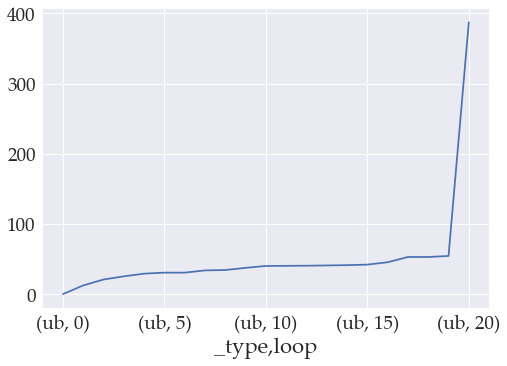

In [37]:
(-sol['λ_emissionsCap']).plot()